In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from censai import RIMUnet, PhysicalModel, RIM, RIMSharedUnet
from censai.models import VAE, VAESecondStage, SharedUnetModel, UnetModel
from censai.utils import rim_residual_plot, update
from censai.data.lenses_tng import decode_train, decode_physical_model_info
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from argparse import Namespace
import math, json
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 100)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

# NIE no shift

In [2]:
hparamsSUNS = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIEns.csv"), index_col=0)
hparamsDUNS = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIEns.csv"), index_col=0)
hparamsSUS  = pd.read_csv(os.path.join(result_dir, "RIMSU512_k128_NIEs.csv"), index_col=0)
hparamsDUS  = pd.read_csv(os.path.join(result_dir, "RIMDU512_k128_NIEs.csv"), index_col=0)

columns = ["seed", "batch_size", "total_items", "train_cost", "train_chi_squared", "best_score", "experiment_id"]
hparams = pd.concat([df[columns] for df in [hparamsSUNS, hparamsDUNS, hparamsSUS, hparamsDUS]])
hparams["shift"] = ["ns" not in experiment_id for experiment_id in hparams["experiment_id"]]

# histories = {}
# for file in hparams["experiment_id"]:
#     histories.update({file: pd.read_csv(os.path.join(result_dir, file + ".csv"), index_col=0).to_dict()})
hparams[["seed", "shift", "batch_size", "total_items", "train_cost", "train_chi_squared", "best_score", "experiment_id"]].sort_values(by="train_chi_squared")

,seed,shift,batch_size,total_items,train_cost,train_chi_squared,best_score,experiment_id
0,42,False,1,2,0.002282,53.079716,0.002000,RIMDU512_k128_NIEns_000_TI2_42_B1_D0_210918041519
19,32,True,5,1000,0.005265,70.923020,0.004462,RIMSU512_k128_NIEs_019_TI1000_32_B5_210918011431
7,142,False,2,2,0.002834,74.616820,0.002785,RIMDU512_k128_NIEns_007_TI2_142_B2_D5_210918042548
6,16,True,1,100,0.010121,75.517456,0.007047,RIMSU512_k128_NIEs_006_TI100_16_B1_210918004441
17,16,True,5,1000,0.006212,75.564730,0.005990,RIMSU512_k128_NIEs_017_TI1000_16_B5_210918010833
11,2,True,5,1000,0.008103,78.972450,0.006418,RIMSU512_k128_NIEs_011_TI1000_2_B5_210918005034
2,4,False,1,5,0.006763,84.743700,0.006368,RIMSU512_k128_NIEns_002_TI5_4_B1_210918032113
6,16,False,1,5,0.008676,84.955490,0.006583,RIMSU512_k128_NIEns_006_TI5_16_B1_210918033223
11,4,False,5,10,0.014593,87.286470,0.009920,RIMSU512_k128_NIEns_011_TI10_4_B5_210918033730
30,16,False,1,1000,0.006043,92.585820,0.006035,RIMSU512_k128_NIEns_030_TI1000_16_B1_210918041440


In [3]:
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models/RIMSU512_k128_NIEs_019_TI1000_32_B5_210918011431")
# checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models", "RIMSU512_k128_NIEs_017_TI1000_16_B5_210918010833")
checkpoints_dir = os.path.join(os.getenv("CENSAI_PATH"), "models", "RIMSU512_k128_NIEns_030_TI1000_16_B1_210918041440")
with open(os.path.join(checkpoints_dir, "script_params.json"), "r") as f:
    args = json.load(f)
args = Namespace(**args)

tf.random.set_seed(args.seed)
np.random.seed(args.seed)
files = []
for dataset in [os.path.join(os.getenv('CENSAI_PATH'), "data", "lenses512_k128_NIE_10k")]:
    files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                           block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
# Read off global parameters from first example in dataset
for physical_params in dataset.map(decode_physical_model_info):
    break
dataset = dataset.map(decode_train).batch(1)
dataset = dataset.take(args.total_items)


In [4]:

phys = PhysicalModel(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method=args.forward_method,
    noise_rms=physical_params["noise rms"].numpy(),
    psf_sigma=physical_params["psf sigma"].numpy()
)

unet = SharedUnetModel(
    filters=args.filters,
    filter_scaling=args.filter_scaling,
    kernel_size=args.kernel_size,
    layers=args.layers,
    block_conv_layers=args.block_conv_layers,
    strides=args.strides,
    bottleneck_kernel_size=args.bottleneck_kernel_size,
    bottleneck_filters=args.bottleneck_filters,
    resampling_kernel_size=args.resampling_kernel_size,
    gru_kernel_size=args.gru_kernel_size,
    upsampling_interpolation=args.upsampling_interpolation,
    kernel_regularizer_amp=args.kernel_regularizer_amp,
    bias_regularizer_amp=args.bias_regularizer_amp,
    activation=args.activation,
    alpha=args.alpha,
    initializer=args.initializer,
)
rim = RIMSharedUnet(
    physical_model=phys,
    unet=unet,
    steps=args.steps,
    adam=args.adam,
    kappalog=args.kappalog,
    source_link=args.source_link,
    kappa_normalize=args.kappa_normalize,
    kappa_init=args.kappa_init,
    source_init=args.source_init
)
ckpt = tf.train.Checkpoint(net=rim.unet)
checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()

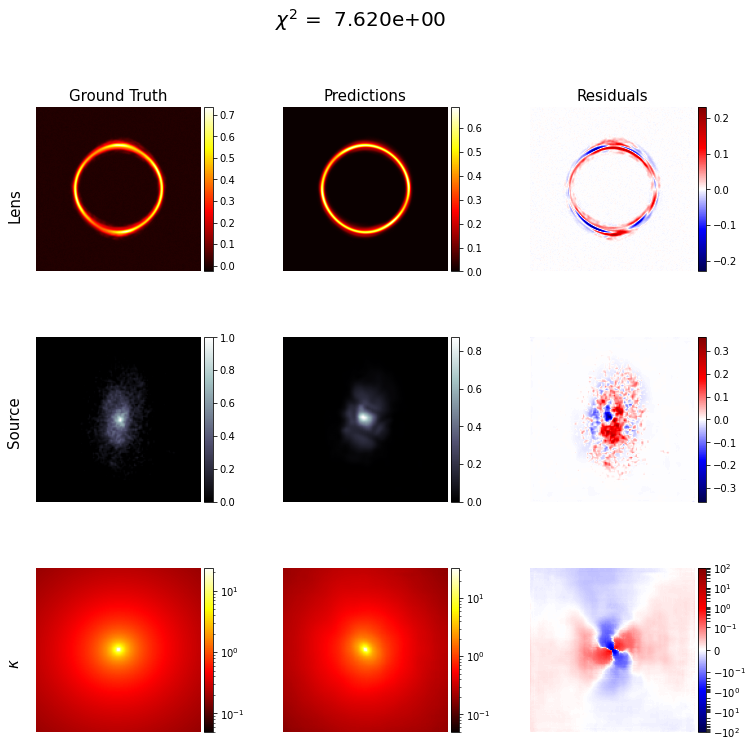

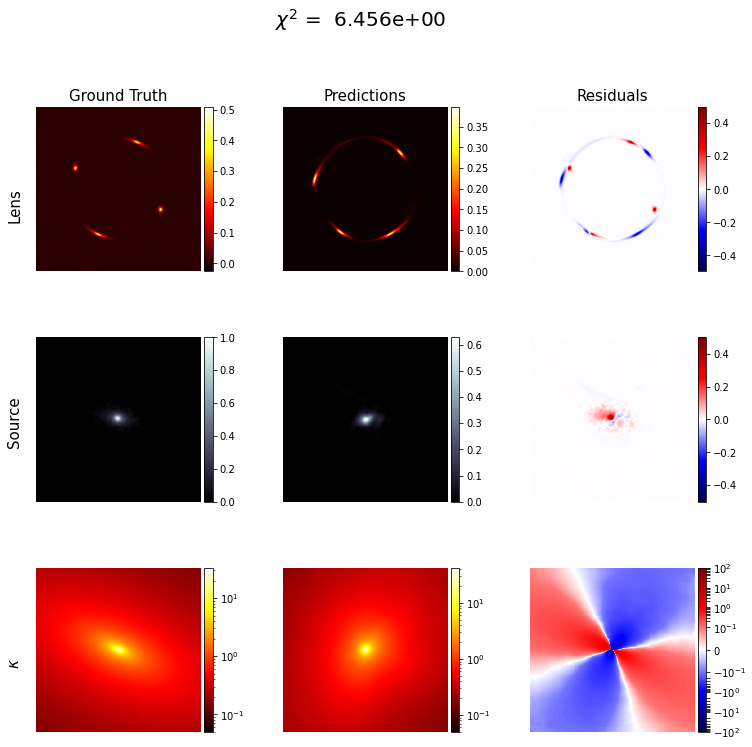

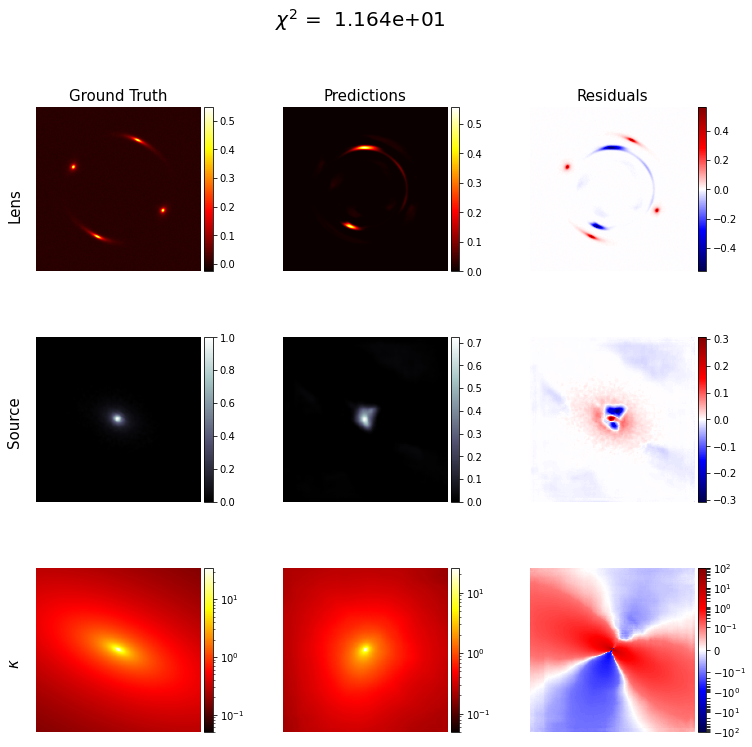

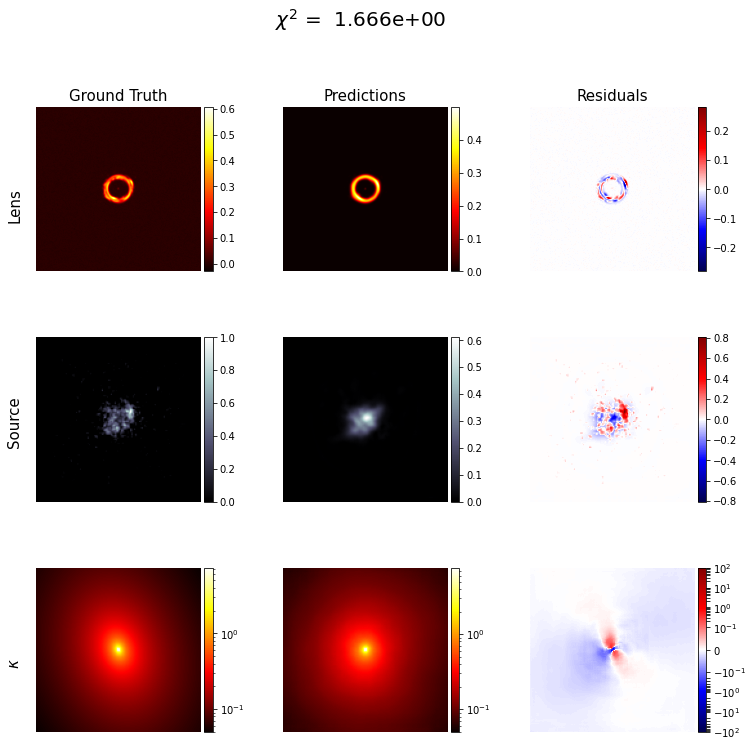

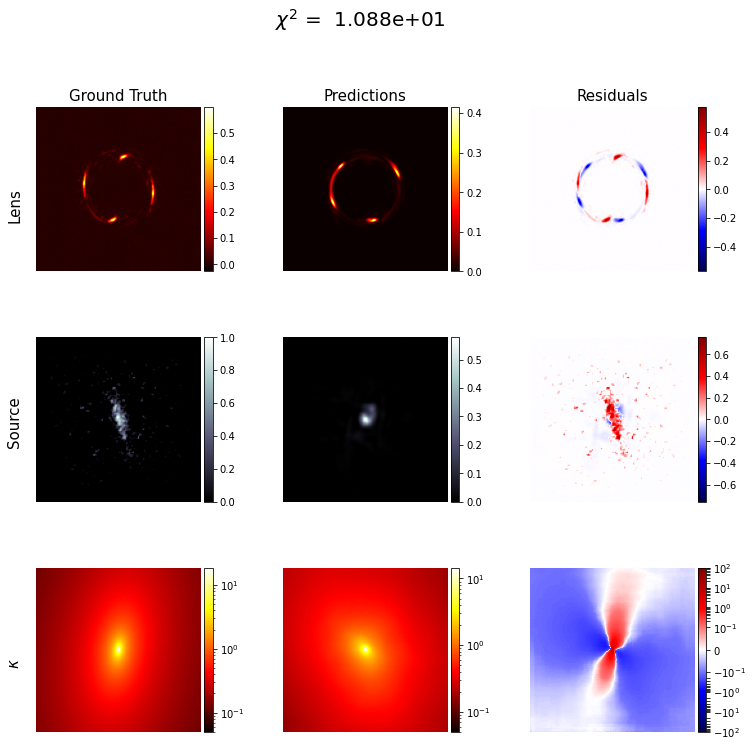

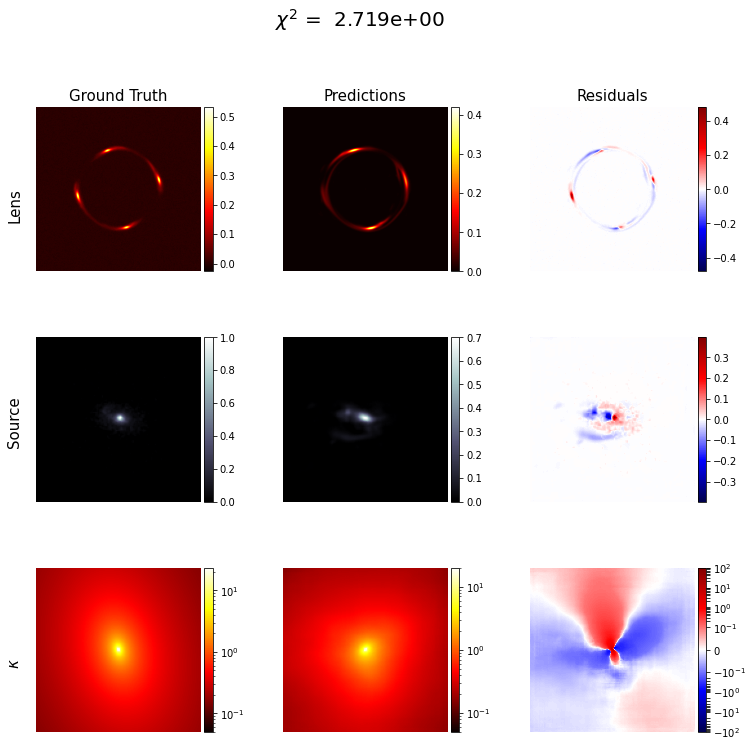

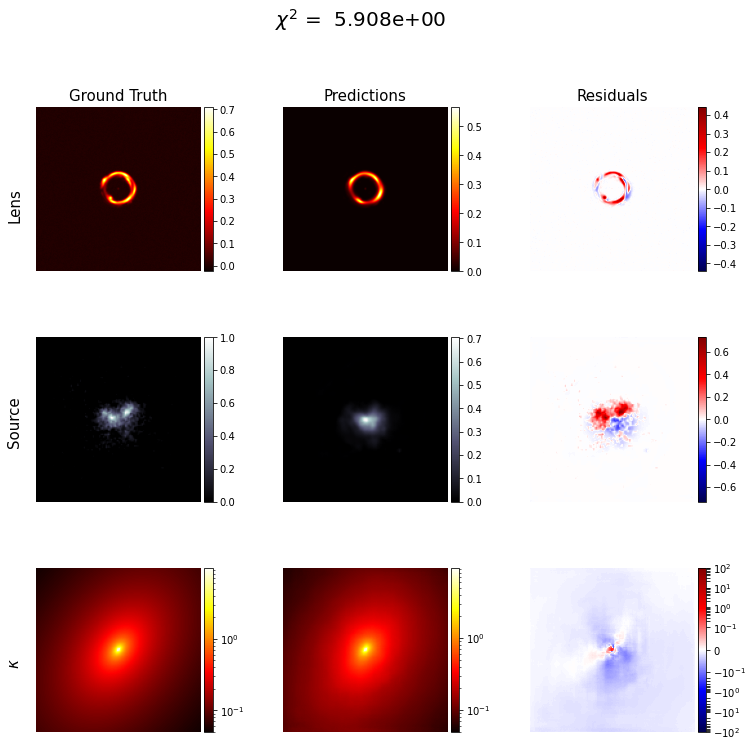

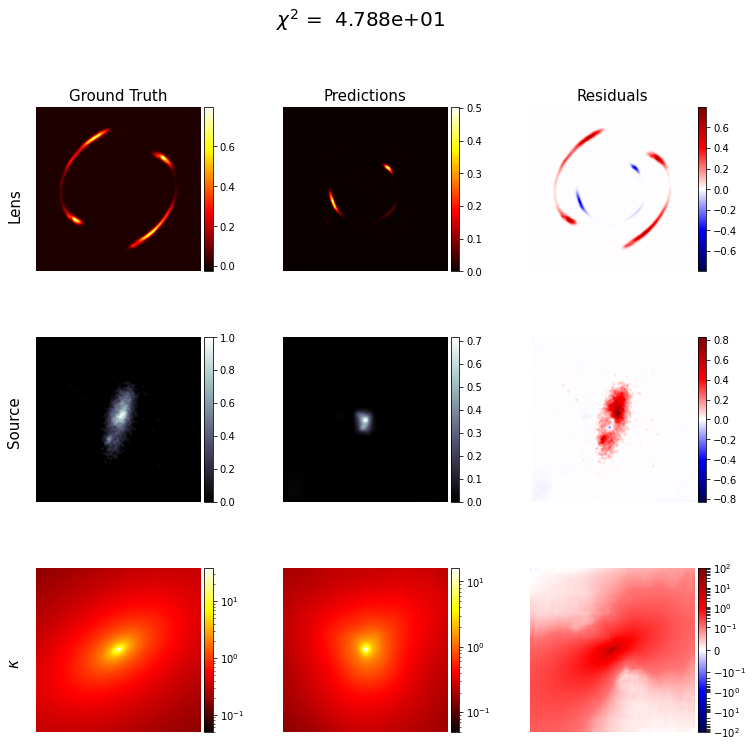

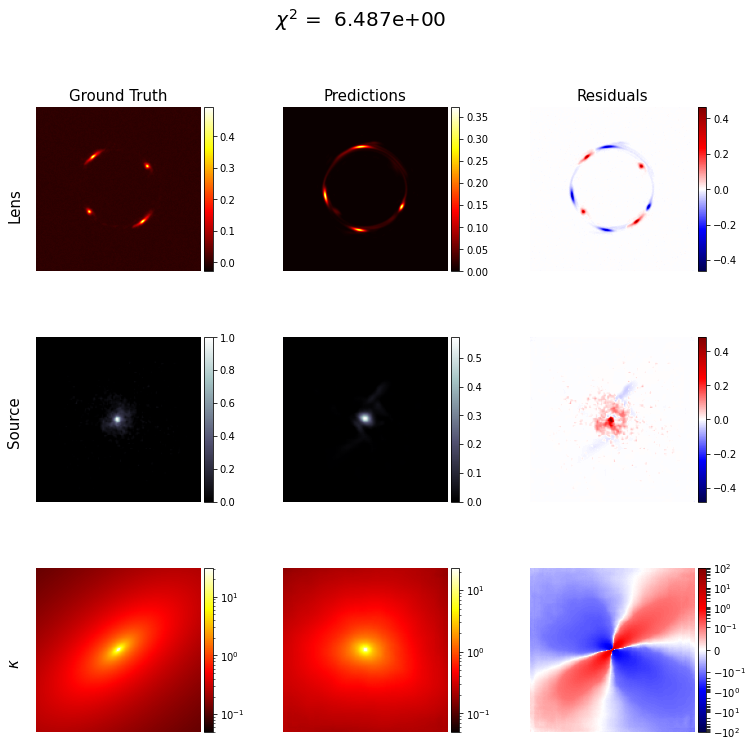

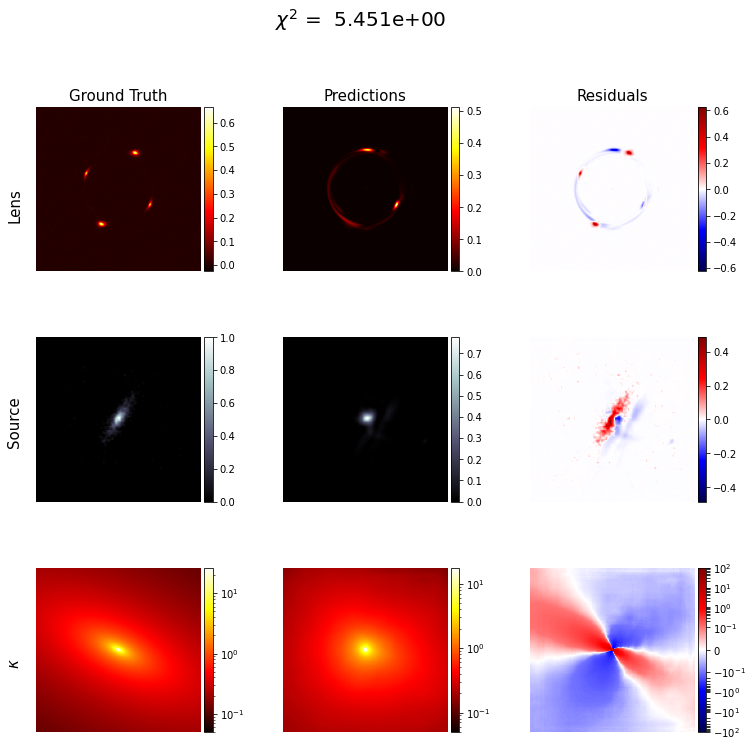

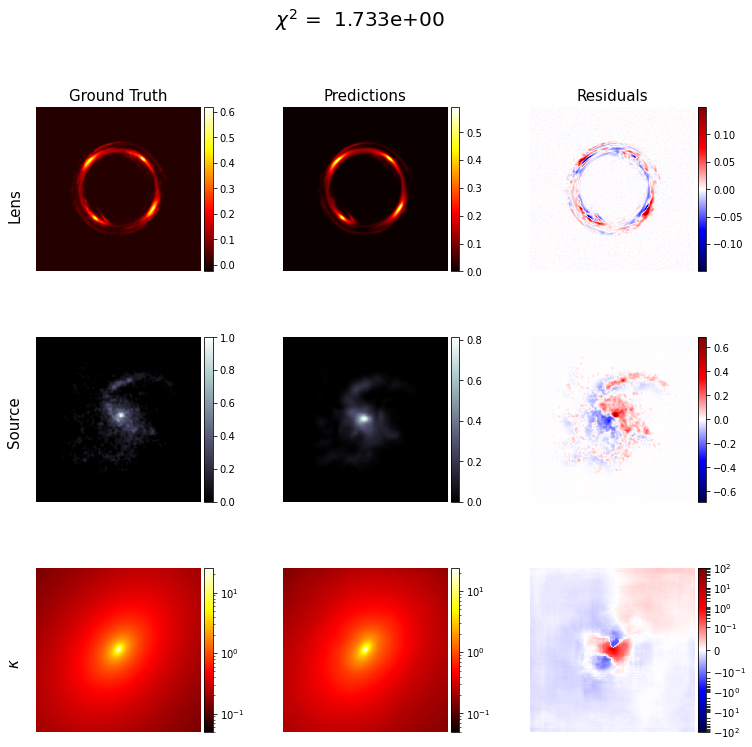

In [6]:
i = 0
index = 0
for batch, (X, source, kappa) in enumerate(dataset):
    source_pred, kappa_pred, chi_squared = rim.predict(X)
    lens_pred = phys.forward(source_pred[-1], kappa_pred[-1])
    rim_residual_plot(
        X[index], source[index], kappa[index], lens_pred[index], source_pred[-1][index],
        kappa_pred[-1][index], chi_squared[-1][index]
    )
    if i == 10:
        break
    i += 1